# Exercise 4: Parallel merge sort

In [1]:
# Implementation of merge sort with non-parallel and parallel options
from multiprocess import Pipe, Process

def merge_sort(data, conn=None, parallel=False):
    if len(data) <= 1:
        if conn:  # Check if Connection object is passed to merge_sort
            conn.send(data)  # Return sorted sub-list to parent Process
            conn.close()  # Close the Connection
        return data  # Non-parallel: just return sorted sub-list
    else:
        split = len(data) // 2

        if parallel:  # Parallel merge sort
            # Create pipes for inter-process communication
            left_conn, left_conn_child = Pipe()
            right_conn, right_conn_child = Pipe()

            # Create processes for sorting each half of the list
            left_process = Process(target=merge_sort,
                                   args=(data[:split], left_conn_child))
            right_process = Process(target=merge_sort,
                                    args=(data[split:], right_conn_child))

            # Start the processes
            left_process.start()
            right_process.start()

            # Get sorted sub-lists from the child processes
            left_sorted = left_conn.recv()
            right_sorted = right_conn.recv()

            # Wait for processes to finish
            left_process.join()
            right_process.join()
        else:  # Non-parallel merge sort
            left_sorted = merge_sort(data[:split], parallel=False)
            right_sorted = merge_sort(data[split:], parallel=False)

        # Merge sorted sub-lists
        result = []
        left, right = iter(left_sorted), iter(right_sorted)
        left_top, right_top = next(left, None), next(right, None)

        while left_top is not None or right_top is not None:
            if right_top is None or (left_top is not None
                                     and left_top < right_top):
                result.append(left_top)
                left_top = next(left, None)
            else:
                result.append(right_top)
                right_top = next(right, None)

        if conn:
            conn.send(result)
            conn.close()
        return result

In [2]:
# Measure time complexity of merge_sort()
import numpy as np
import time

# Generate sample sizes n
n_values = np.logspace(1, 7, num = 10, base = 10).astype(int)

# Store performance time results
times = []

for n in n_values:
    # Generate random data
    data = np.random.rand(n)

    # Start timer
    start = time.perf_counter()

    # Sort the data
    sorted_data = merge_sort(data, parallel=False)

    # Stop timer
    end = time.perf_counter()

    # Calculate elapsed time
    elapsed = end - start

    # Store performance time
    times.append(elapsed)

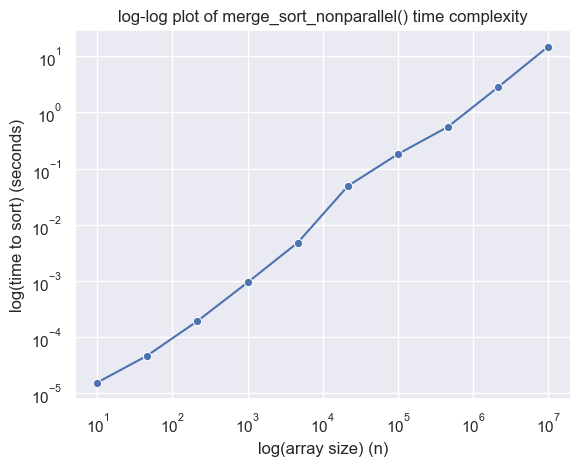

In [3]:
# Plot time complexity of merge_sort()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

df = pd.DataFrame({
    'Array Size': n_values,
    'Time': times
})

sns.set_theme(style="darkgrid")
ax = sns.lineplot(x='Array Size', y='Time', data=df, marker='o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('log(array size) (n)')
ax.set_ylabel('log(time to sort) (seconds)')
plt.title('log-log plot of merge_sort_nonparallel() time complexity')
plt.show()

In [4]:
# Comparison of performance
import time
import numpy as np

# Generate n values
n_values = np.logspace(1, 7, num = 10, base = 10).astype(int)

# Track performance
nonparallel_times = []
parallel_times = []

if __name__ == "__main__": # Prevent child processes from spawning recursively
    for n in n_values:
        # Generate random data
        data = np.random.rand(n)

        # Keep data consistent for non-parallel
        data_nonparallel = np.copy(data)

        # Start timer
        start = time.perf_counter()

        # Sort the data
        sorted_data_nonparallel = merge_sort(data, parallel = False)

        # Stop timer
        end = time.perf_counter()

        # Calculate elapsed time
        elapsed = end - start

        # Store performance time
        nonparallel_times.append(elapsed)

        # Keep data consistent for parallel
        data_parallel = np.copy(data)

        # Start timer
        start = time.perf_counter()

        # Sort the data
        sorted_data_parallel = merge_sort(data, parallel = True)

        # Stop timer
        end = time.perf_counter()

        # Calculate elapsed time
        elapsed = end - start

        # Store performance time
        parallel_times.append(elapsed)       

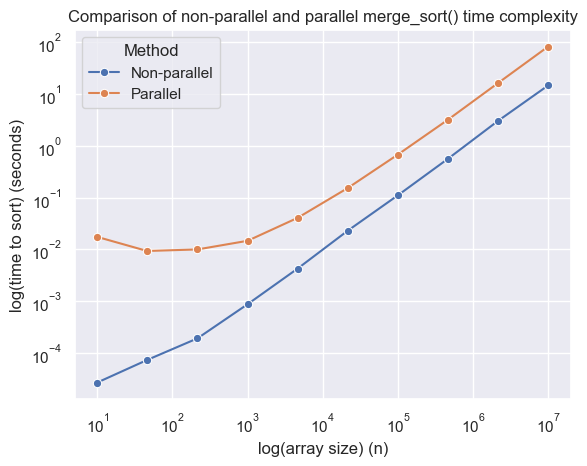

In [5]:
# Compare time complexity of combined merge_sort()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

df = pd.DataFrame({
    "Array Size": np.concatenate([n_values, n_values]),
    "Time": nonparallel_times + parallel_times,
    "Method": ['Non-parallel'] * len(nonparallel_times) + ['Parallel'] * len(parallel_times)
})

sns.set_theme(style="darkgrid")
ax = sns.lineplot(data=df, x="Array Size", y="Time", hue="Method", marker="o")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("log(array size) (n)")
ax.set_ylabel("log(time to sort) (seconds)")
plt.title("Comparison of non-parallel and parallel merge_sort() time complexity")
plt.show()

**Discussion of findings:** The parallel version of `merge_sort()` should be faster, but the plot shows that it is somehow slower than the non-parallel version. 